### Arrhythmia Dataset

#### Number of Samples: 109446, Number of Categories: 5, Sampling Frequency: 125Hz
#### Data Source: MIT-BIH Arrhythmia Dataset, Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed

import warnings
warnings.filterwarnings("ignore")


In [4]:
# Load datasets from MIT-BIH
train_data = pd.read_csv('/Users/ohajati/Desktop/ECG/mitbih_train.csv', header=None)  
test_data = pd.read_csv('/Users/ohajati/Desktop/ECG/mitbih_test.csv', header=None)    

# Load datasets from PTBDB
ptbdb_normal = pd.read_csv('/Users/ohajati/Desktop/ECG/ptbdb_normal.csv', header=None)  
ptbdb_abnormal = pd.read_csv('/Users/ohajati/Desktop/ECG/ptbdb_abnormal.csv', header=None)





In [19]:
# Check for missing values and data types
print(train_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None


In [5]:
#visulizations and represtentations
train_data[187].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

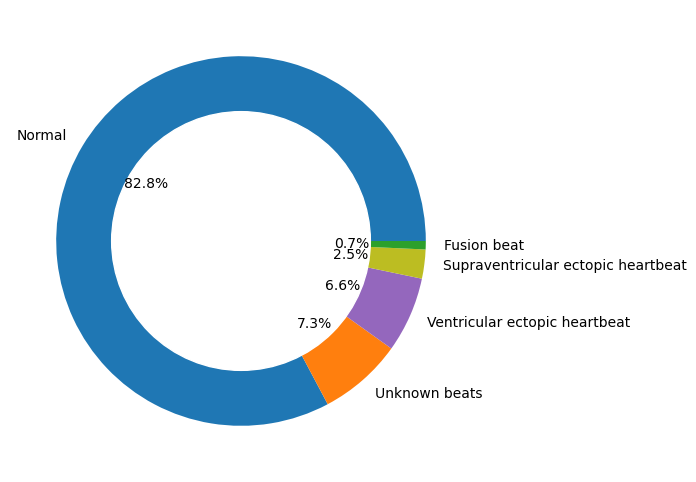

In [12]:
per_class = train_data[187].value_counts()
plt.figure(figsize=(6,6))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['Normal','Unknown beats','Ventricular ectopic heartbeat','Supraventricular ectopic heartbeat','Fusion beat'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

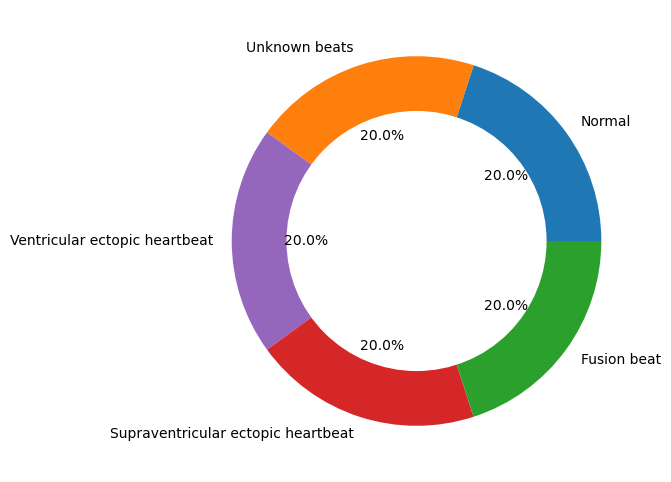

In [18]:
# Create a dictionary to store the resampled DataFrames
resampled_data = {}

# Resample the normal class (0) without replacement
resampled_data[0] = train_data[train_data[187] == 0].sample(n=20000, random_state=42)

# Resample other classes (1, 2, 3, 4) with replacement
for label in range(1, 5):
    class_data = train_data[train_data[187] == label]
    resampled_data[label] = resample(class_data, replace=True, n_samples=20000, random_state=label + 123)

# Combine all resampled DataFrames into one
train_data = pd.concat(resampled_data.values())

# Count the occurrences of each class
per_class = train_data[187].value_counts()

# Plotting the distribution
plt.figure(figsize=(6, 6))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['Normal','Unknown beats','Ventricular ectopic heartbeat','Supraventricular ectopic heartbeat','Fusion beat'], 
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [21]:
classes=train_data.groupby(187,group_keys=False).apply(lambda train_data : train_data.sample(1))
classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
65928,0.986971,1.000000,0.260586,0.074919,0.120521,0.107492,0.100977,0.100977,0.087948,0.104235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73218,0.983456,0.917279,0.338235,0.082721,0.053309,0.025735,0.053309,0.102941,0.172794,0.336397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76456,0.000000,0.067103,0.121113,0.258592,0.324059,0.423895,0.487725,0.423895,0.381342,0.397709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
81039,0.858195,0.931860,1.000000,0.790055,0.458564,0.255985,0.163904,0.134438,0.114180,0.103131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
84631,0.923163,0.867483,0.804009,0.750557,0.688196,0.606904,0.531180,0.393096,0.302895,0.227171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


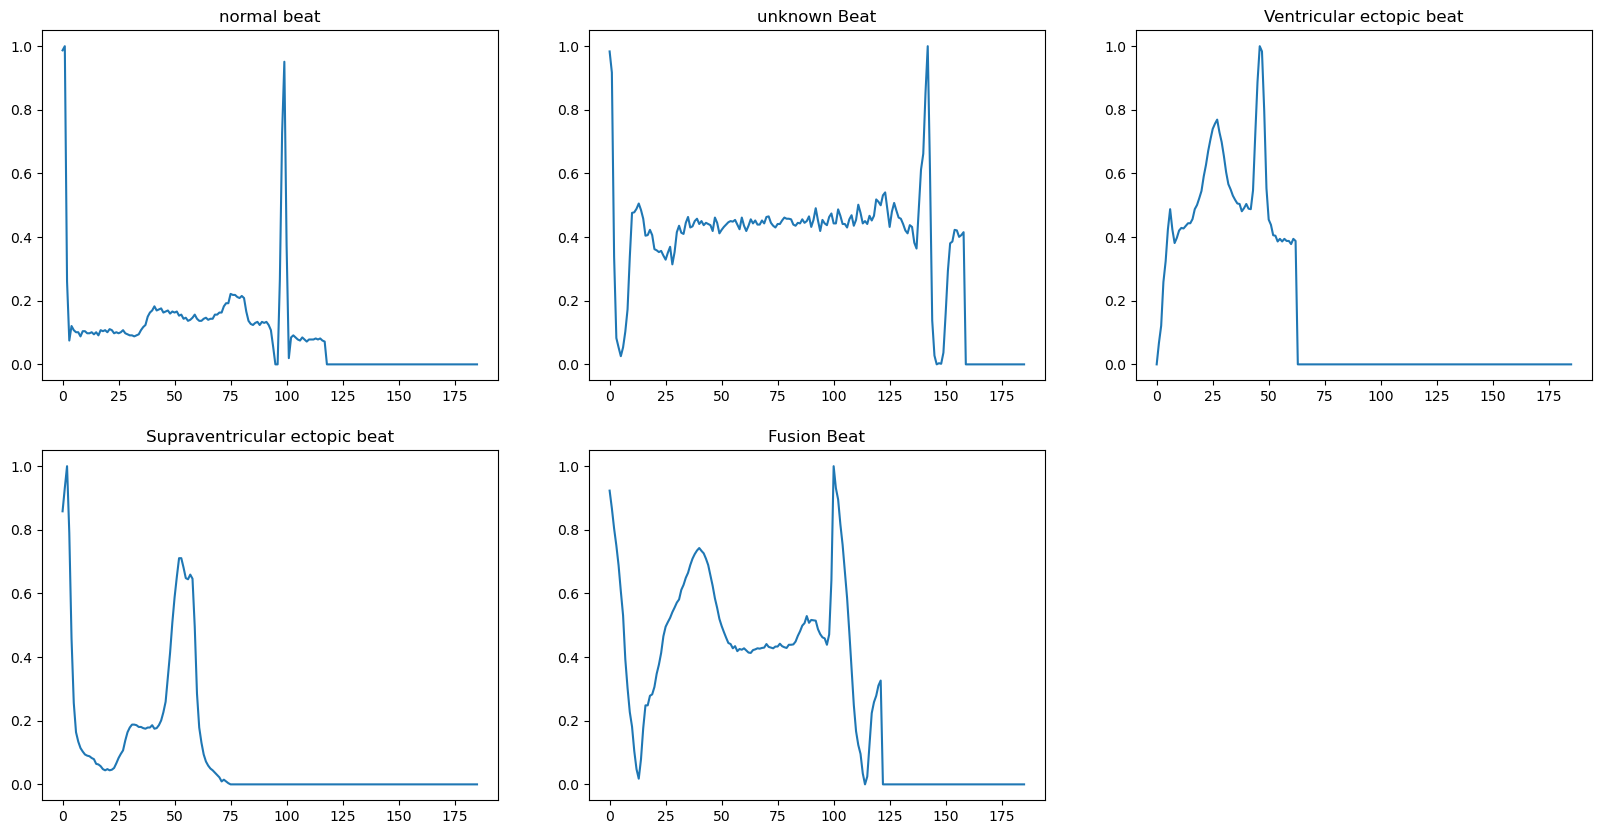

In [25]:
# plotting classes ECG
plt.figure(figsize=(20,10))
# Normal
plt.subplot(2, 3, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('normal beat')
# Unknown
plt.subplot(2, 3, 2)  
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
# Ventricular ectopic beat
plt.subplot(2, 3, 3)  
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
# Supraventricular ectopic beat
plt.subplot(2, 3, 4)  
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
# Fusion
plt.subplot(2, 3, 5)  
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
# show plot
plt.show()

In [5]:
# Split MIT-BIH training data into features and target
X_train_mitbih = train_data.iloc[:, :-1].values
y_train_mitbih = train_data.iloc[:, -1].values

X_test_mitbih = test_data.iloc[:, :-1].values
y_test_mitbih = test_data.iloc[:, -1].values

In [11]:
y_train_mitbih


array([0., 0., 0., ..., 4., 4., 4.])

In [12]:
# Normalize MIT-BIH data
scaler_mitbih = StandardScaler()
X_train_mitbih_scaled = scaler_mitbih.fit_transform(X_train_mitbih)
X_test_mitbih_scaled = scaler_mitbih.transform(X_test_mitbih)

In [15]:
# Build a neural network model for MIT-BIH
model_mitbih = keras.Sequential([
    layers.Input(shape=(X_train_mitbih_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [20]:
model_mitbih.compile(optimizer='adam',
                     loss='binary_crossentropy',  
                     metrics=['accuracy'])

In [21]:
# Train the model on MIT-BIH data
model_mitbih.fit(X_train_mitbih_scaled, y_train_mitbih, epochs=50, batch_size=32)

Epoch 1/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step - accuracy: 0.6228 - loss: -14163.5156
Epoch 2/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step - accuracy: 0.6094 - loss: -357684.5625
Epoch 3/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step - accuracy: 0.6049 - loss: -1472605.3750
Epoch 4/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step - accuracy: 0.6029 - loss: -3634591.2500
Epoch 5/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step - accuracy: 0.6001 - loss: -7023640.5000
Epoch 6/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 264us/step - accuracy: 0.6026 - loss: -11668049.0000
Epoch 7/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.6033 - loss: -17891104.0000
Epoch 8/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.6032 - loss: -26528866.0000
Epoch 9/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step - accuracy: 0.5998 - loss: -37076872.0000
Epoch 10/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step - accuracy: 0.6084 - loss: -49053872.0000
Epoch 11/50
2737/2737 ━━━━━

In [22]:
# Evaluate the model on the MIT-BIH test set
val_loss_mitbih, val_accuracy_mitbih = model_mitbih.evaluate(X_test_mitbih_scaled, y_test_mitbih)
print(f"MIT-BIH Test Loss: {val_loss_mitbih}, Test Accuracy: {val_accuracy_mitbih}")

685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.6906 - loss: 1273438464.0000
MIT-BIH Test Loss: -5201054208.0, Test Accuracy: 0.595651388168335


## Potential reasons for low performances: Model Complexitye, Data Imbalance,Feature Scaling,Learning Rate.

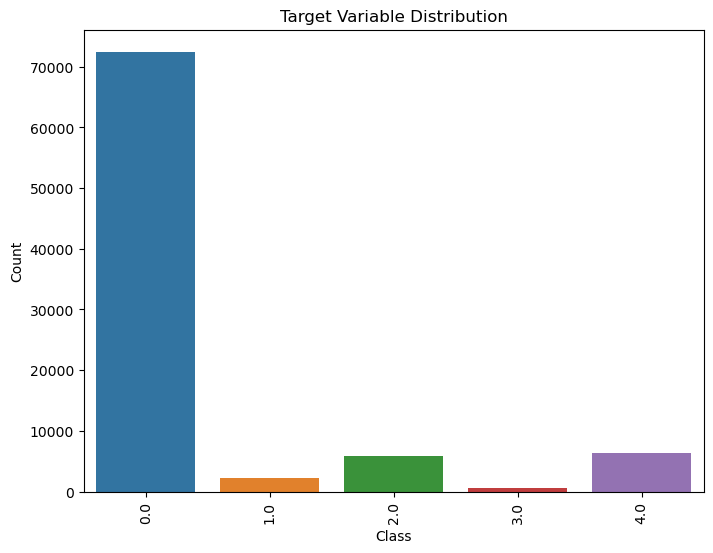

In [28]:
# Assuming y_train is your target variable
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_mitbih)
plt.title('Target Variable Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [34]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
classes = np.unique(y_train_mitbih)  # Get unique classes from your target variable
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_mitbih)

# Convert to dictionary format
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Now use this class_weight_dict in model fitting
model_mitbih.fit(X_train_mitbih, y_train_mitbih, epochs=50, batch_size=32, class_weight=class_weight_dict)


Epoch 1/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - accuracy: 0.1129 - loss: -6898501632.0000
Epoch 2/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 317us/step - accuracy: 0.0648 - loss: -8531343360.0000
Epoch 3/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.0512 - loss: -9612286976.0000
Epoch 4/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - accuracy: 0.0442 - loss: -11093712896.0000
Epoch 5/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - accuracy: 0.0392 - loss: -11808204800.0000
Epoch 6/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - accuracy: 0.0360 - loss: -12622606336.0000
Epoch 7/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.0323 - loss: -14012122112.0000
Epoch 8/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.0292 - loss: -15667575808.0000
Epoch 9/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step - accuracy: 0.0282 - loss: -16563968000.0000
Epoch 10/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.0269 - loss: -181775912

In [35]:
# Load datasets from PTBDB
ptbdb_normal = pd.read_csv('/Users/ohajati/Desktop/ECG/ptbdb_normal.csv', header=None)  # Adjust the file path
ptbdb_abnormal = pd.read_csv('/Users/ohajati/Desktop/ECG/ptbdb_abnormal.csv', header=None)  # Adjust the file path

# Combine PTBDB datasets and prepare for training
normal_labels = np.zeros(ptbdb_normal.shape[0])  # Label normal as 0
abnormal_labels = np.ones(ptbdb_abnormal.shape[0])  # Label abnormal as 1

X_ptbdb = pd.concat([ptbdb_normal, ptbdb_abnormal], ignore_index=True).values
y_ptbdb = np.concatenate([normal_labels, abnormal_labels])

# Normalize PTBDB data
scaler_ptbdb = StandardScaler()
X_ptbdb_scaled = scaler_ptbdb.fit_transform(X_ptbdb)

# Split PTBDB data into training and validation sets
X_train_ptbdb, X_val_ptbdb, y_train_ptbdb, y_val_ptbdb = train_test_split(X_ptbdb_scaled, y_ptbdb, test_size=0.2, random_state=42)

# Build a neural network model for PTBDB
model_ptbdb = keras.Sequential([
    layers.Input(shape=(X_train_ptbdb.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Adjust for multi-class if needed
])

# Compile the model
model_ptbdb.compile(optimizer='adam',
                    loss='binary_crossentropy',  # Change if multi-class
                    metrics=['accuracy'])

# Train the model on PTBDB data
model_ptbdb.fit(X_train_ptbdb, y_train_ptbdb, epochs=50, batch_size=32, validation_data=(X_val_ptbdb, y_val_ptbdb))

# Evaluate the model on the PTBDB validation set
val_loss_ptbdb, val_accuracy_ptbdb = model_ptbdb.evaluate(X_val_ptbdb, y_val_ptbdb)
print(f"PTBDB Validation Loss: {val_loss_ptbdb}, Validation Accuracy: {val_accuracy_ptbdb}")

Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.8884 - loss: 0.2611 - val_accuracy: 0.9979 - val_loss: 0.0099
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.9985 - loss: 0.0068 - val_accuracy: 0.9928 - val_loss: 0.0182
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - accuracy: 0.9979 - loss: 0.0088 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 1.0000 - loss: 4.8106e-04 - val_accuracy: 0.9976 - val_loss: 0.0049
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - accuracy: 1.0000 - loss: 4.3977e-04 - val_accuracy: 1.0000 - val_loss: 5.0181e-04
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - accuracy: 1.0000 - loss: 1.1060e-04 - val_accuracy: 1.0000 - val_loss: 4.3297e-04
Epoch 7/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - accuracy: 1.0000 - loss: 7.5183e-05 - val_accuracy: 1.0000 - val_loss: 3.6468e-04
Epoch 8/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accura